In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline


In [9]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [10]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

In [11]:
team_1 = 'Sunrisers Hyderabad'
team_2 = 'Mumbai Indians'

In [12]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

In [13]:
def clean(row):
    if row['extra_runs']>= row['batsman_runs']:
        row['extra_runs'] -= row['batsman_runs']
        
    return row

delivery = delivery.apply(clean, axis=1)
delivery['total_runs'] = delivery['extra_runs'] + delivery['batsman_runs']

# Winning Probability of Teams

Text(0.5, 1.0, 'MI Total Runs Score Stats Per Count')

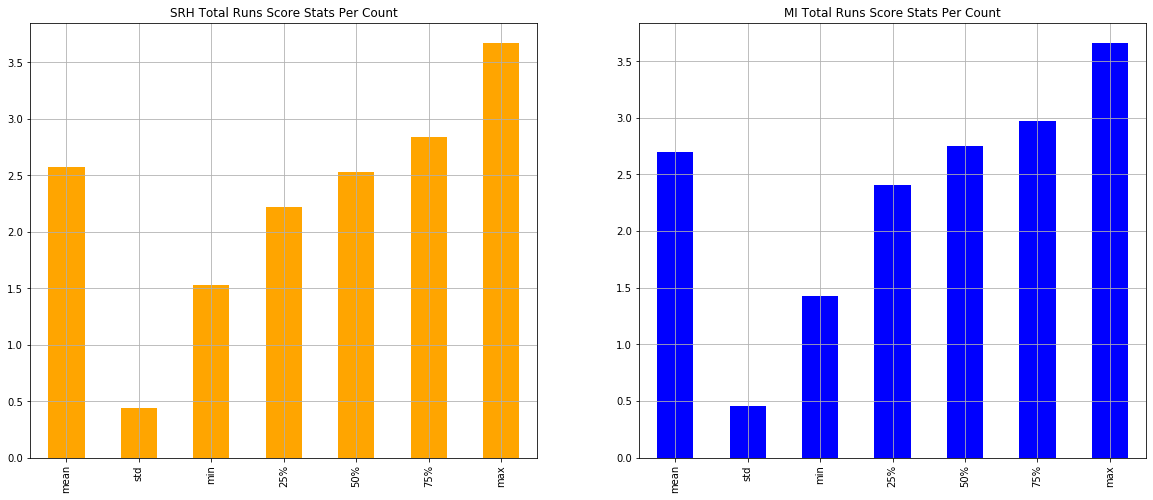

In [16]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
srh_runs = delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['total_runs']
mi_runs = delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['total_runs']
(srh_runs.describe()[1:]/srh_runs.describe()[0]).plot(ax=ax[0], kind='bar', grid=True, color='orange')
(mi_runs.describe()[1:]/mi_runs.describe()[0]).plot(ax=ax[1], kind='bar', grid=True, color='blue')
ax[0].set_title("SRH Total Runs Score Stats Per Count")
ax[1].set_title("MI Total Runs Score Stats Per Count")

Text(0.5, 1.0, 'Percentage of Winning')

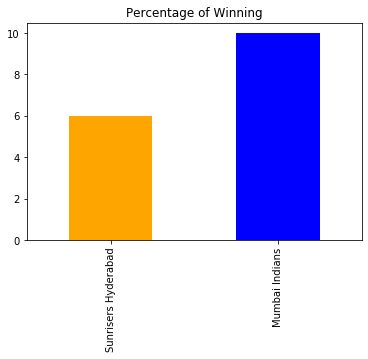

In [35]:
matches1[matches1['season']>=2019]['winner'].value_counts()[[team_1, team_2]].plot(kind='bar', color=['orange', 'blue'])
plt.title('Percentage of Winning')

# Stamina Score

In [50]:
mi_team = ['RG Sharma', 'Q de Kock', 'SA Yadav', 'Ishan Kishan', 'HH Pandaya', 'KH Pandaya', 'NM Coulter-Nile', 'RD Chahar', 'JJ Bumrah', 'TA Boult']
srh_team = ['DA Warner', 'J Bairstow', 'WP Saha', 'MK Pandey', 'KS Williamson', 'Rashid Khan', 'K Ahmed', 'T Natarajan']

In [55]:
def stamina_score(batsmen):
    stamina_ratio = list()
    for match_id in delivery[(delivery['batsman']==batsmen)]['match_id'].unique():
        match = delivery[(delivery['batsman']==batsmen) & (delivery['match_id']==match_id)]
        t_runs = sum(match['batsman_runs'])
        if t_runs > 15:
            s_runs = sum(match[match['batsman_runs'].isin([1, 2, 3])]['batsman_runs'])
            b_runs =  sum(match[match['batsman_runs'].isin([4, 6])]['batsman_runs'])
            balls = len(match)
            crease_balls = len(delivery[(delivery['match_id']==match_id) & (delivery['batsman']==batsmen) | (delivery['non_striker']==batsmen)])
            stamina = ((s_runs/(b_runs+1)) + (balls/(crease_balls+1)))/t_runs
            stamina_ratio.append([batsmen, stamina])
    return stamina_ratio

In [47]:
def normalize(values):
    max_value = max(values)
    min_value = min(values)
    new = list()
    for v in values:
        new_v = (v - min_value)/(max_value-min_value)
        new.append(new_v)
    return new
    

In [58]:
batsman_stamina = list()
for batsman in (mi_team+srh_team):
    batsman_stamina += (stamina_score(batsman))

In [62]:
stamina_score_df = pd.DataFrame(data=batsman_stamina, columns=['Batsman', 'Stamina Score'])
stamina_score_df['Stamina Score'] = normalize(stamina_score_df['Stamina Score'])

Text(0.5, 1.0, 'Mean Stamina Score')

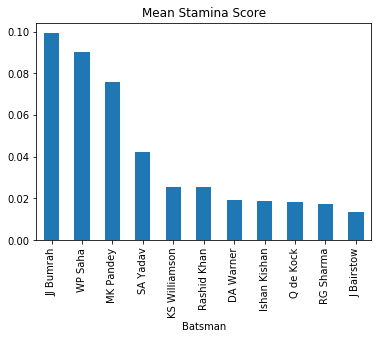

In [88]:
stamina_score_df.groupby('Batsman').mean()['Stamina Score'].sort_values(ascending=False).plot(kind='bar')
plt.title("Mean Stamina Score")

Considering only front line batsman, the two will be WP Saha and SA Yadav

# Smash Rate

In [66]:
def smash_rate(batsmen):
    rates = list()
    for match_id in delivery[(delivery['batsman']==batsmen)]['match_id'].unique():
        match = delivery[(delivery['batsman']==batsmen) & (delivery['match_id']==match_id)]
        balls = len(match)
        boundaries = len(match[match['batsman_runs'].isin([4, 6])]['batsman_runs'])
        if balls>0:
            rate = boundaries*100/balls
            rates.append([batsmen, rate])
    return rates

In [67]:
batsman_smash = list()
for batsman in (mi_team+srh_team):
    batsman_smash += smash_rate(batsman)

Text(0.5, 1.0, 'Mean Smash Rate')

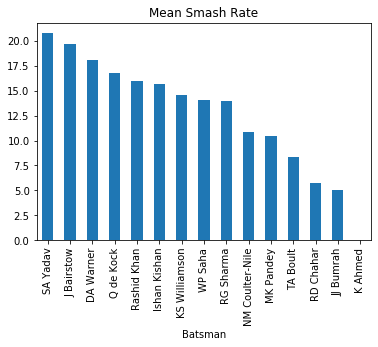

In [87]:
smash_rate_df = pd.DataFrame(data=batsman_smash, columns=['Batsman', 'Smash Rate'])
smash_rate_df.groupby('Batsman').mean()['Smash Rate'].sort_values(ascending=False).plot(kind='bar')
plt.title("Mean Smash Rate")

# Boundary Leaker

In [72]:
def boundary_leaker(bowler):
    bl = list()
    for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
        match = delivery[(delivery['bowler']==bowler) & (delivery['match_id']==match_id)]
        balls = len(match)
        boundaries = len(match[match['total_runs'].isin([4, 5, 6, 7])])
        x = balls/(boundaries+1)
        bl.append([bowler, x])
    return bl

In [73]:
bowler_bl = list()
for bowler in (mi_team+srh_team):
    bowler_bl += boundary_leaker(bowler)
    

Text(0.5, 1.0, 'Mean boundary leaker score per bowler (x)')

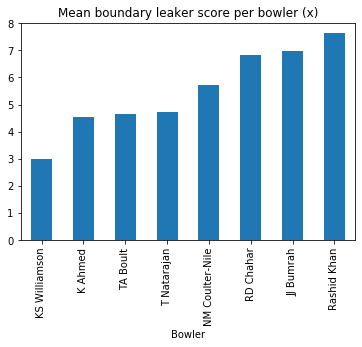

In [86]:
bl_df = pd.DataFrame(data=bowler_bl, columns=['Bowler', 'BL(x)'])
bl_df.groupby('Bowler').mean()['BL(x)'].sort_values().plot(kind='bar')
plt.title("Mean boundary leaker score per bowler (x)")

# Wickets Fall

Text(0.5, 1.0, 'Histogram of Both Teams Wickets Fall per Match')

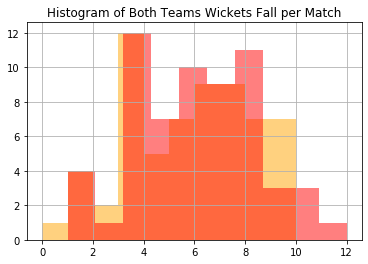

In [84]:
delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['player_dismissed'].hist(alpha=0.5, color='orange')
delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['player_dismissed'].hist(alpha=0.5, color='red')
plt.title("Histogram of Both Teams Wickets Fall per Match")

This plot suggests that the wickets fall highest frequency is generally 4 for both the teams. So, there sum will lie in range 6-10.

# Summary

1. Using the winners column the chances of winning were compared. The total score per match for both the teams were also compared to evaluate their batting performance.
2. Function to calculate stamina score which takes batsman name and calculate single, boundary, total runs and balls and crease balls using batsman_runs column and gives score per match using formula. Mean score is calculated using this formula for each batsman and compared.
3. Function to calculate smash rate is similar to previous function. It just calculates balls and boundaries per match of batsman and gives score using smash rate formula. Mean smash rates were compared.
4. A function to calculate x in boundary leaker was created by filtering data for bowler per match and using total_runs column boundaries was calculated. Using len, balls were calculated and then put in formula. Mean value of x per bowler was compared.
5. Histogram for wickets falls per match for both teams were plotted and range was estimated. 